# Importing necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import cv2
    
import timm
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
set_seed(42)

# Reading the csv's

In [5]:
dftrain = pd.read_csv('/kaggle/input/ai-of-god-v20/train.csv')
dftest = pd.read_csv('/kaggle/input/ai-of-god-v20/test.csv')

In [6]:
print(f"Number of training images: {dftrain.shape[0]}")
print(f"Number of testing images: {dftest.shape[0]}")

Number of training images: 8201
Number of testing images: 2694


In [7]:
dftrain.head()

,FileName,Class
0,1.jpg,0
1,2.jpg,0
2,3.jpg,0
3,4.jpg,0
4,5.jpg,0


In [8]:
dftest.head()

,FileName
0,1.jpg
1,2.jpg
2,3.jpg
3,4.jpg
4,5.jpg


In [9]:
dftrain['Class'].value_counts()

Class
0    4829
1    1405
4     789
3     443
6     295
2     285
7      87
5      68
Name: count, dtype: int64

# A func to append a column for path of all the images

In [10]:
def append_path(df,train=True):
    target_str = []
    for i in range(len(df)):
        target_str.append(str(df['FileName'][i]))
    for i in range(len(df)):
        target_str[i] = target_str[i].replace('.0', '.tif') 
        if train:
            target_str[i] = '/kaggle/input/ai-of-god-v20/train/'+target_str[i]
        else:
            target_str[i] = '/kaggle/input/ai-of-god-v20/test/'+target_str[i]
    df['path'] = target_str
    return df

In [11]:
dftrain = append_path(dftrain)
dftrain.head()

,FileName,Class,path
0,1.jpg,0,/kaggle/input/ai-of-god-v20/train/1.jpg
1,2.jpg,0,/kaggle/input/ai-of-god-v20/train/2.jpg
2,3.jpg,0,/kaggle/input/ai-of-god-v20/train/3.jpg
3,4.jpg,0,/kaggle/input/ai-of-god-v20/train/4.jpg
4,5.jpg,0,/kaggle/input/ai-of-god-v20/train/5.jpg


In [12]:
dftest = append_path(dftest,train=False)
dftest.head()

,FileName,path
0,1.jpg,/kaggle/input/ai-of-god-v20/test/1.jpg
1,2.jpg,/kaggle/input/ai-of-god-v20/test/2.jpg
2,3.jpg,/kaggle/input/ai-of-god-v20/test/3.jpg
3,4.jpg,/kaggle/input/ai-of-god-v20/test/4.jpg
4,5.jpg,/kaggle/input/ai-of-god-v20/test/5.jpg


# Creating the train and val dataset

In [13]:
k_fold_li=[[-1,964,1931,2897,3863,4828],[-1,280,564,845,1127,1404],[-1,57,115,173,231,284],[-1,87,176,266,358,442],[-1,157,315,474,631,788],[-1,13,28,42,53,67],[-1,56,119,179,237,294],[-1,17,35,53,68,86]]
k_fold_li_arr=np.array(k_fold_li).T
k_fold_li_arr
folds={}
for i in range(1,6):
    folds["fold"+str(i)]=pd.DataFrame()
for i in range(1,6):
    for j in range(0,8):    
        folds["fold"+str(i)]=pd.concat([folds["fold"+str(i)],dftrain[dftrain['Class']==j][k_fold_li_arr[i-1][j]+1:k_fold_li_arr[i][j]+1]])
    folds["fold"+str(i)].sample(frac=1)

In [14]:
dic={}
for i in range (1,6):
    dic["dfval"+str(i)]=folds["fold"+str(i)]
    dic["dftrain"+str(i)]=pd.DataFrame()
    for k in range (1,6):
        if(k!=i):
            dic["dftrain"+str(i)]=pd.concat([dic["dftrain"+str(i)],folds["fold"+str(k)]])

In [15]:
dic["dfval"+str(1)]["Class"].value_counts()

Class
0    965
1    281
4    158
3     88
2     58
6     57
7     18
5     14
Name: count, dtype: int64

In [16]:
for key in dic:
    dic[key]=dic[key].sample(frac=1)

In [17]:
dftrain1=dic['dftrain1']
dfval1=dic['dfval1']
dftrain2=dic['dftrain2']
dfval2=dic['dfval2']
dftrain3=dic['dftrain3']
dfval3=dic['dfval3']
dftrain4=dic['dftrain4']
dfval4=dic['dfval4']
dftrain5=dic['dftrain5']
dfval5=dic['dfval5']

# Selecting different hyperparameters

In [18]:
class CFG:
    model_name = 'efficientnet_b3'
    target_size = 8
    size = 227
    batch_size = 32
    epochs = 7
    num_workers = 2
    lr = 1e-3
    weight_decay = 1e-2
    train = True
    target_col = 'Class'

# Train and Test custom dataset class

In [19]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.labels = df['Class'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

# Transformations

In [20]:
def psuedotransforms(*,data):
    return A.Compose([
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1, 1, 1],
        ),
        ToTensorV2(),
    ])

In [21]:
def compute(train_data_func):
    image_dataset = TrainDataset(train_data_func,transform=psuedotransforms(data='train'))
    image_loader = DataLoader(image_dataset,batch_size=16,shuffle=False,num_workers = CFG.num_workers)
    psum    = torch.tensor([0.0,0.0,0.0])
    psum_sq = torch.tensor([0.0,0.0,0.0])

    # loop through images
    for (inputs,targets) in tqdm(image_loader):
        psum    += inputs.sum(axis= [0, 2, 3])
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

    # pixel count
    count = len(train_data_func) * CFG.size * CFG.size
    #print(psum)
    #print(psum_sq)
    # mean and STD
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    #print('Train data stats:')
    print(total_mean)
    print(total_std)

In [22]:
#compute(dftrain1)
mean1=[0.4791, 0.4791, 0.4791]
std1=[0.1871, 0.1871, 0.1871]
"""tensor([0.4791, 0.4791, 0.4791])
tensor([0.1871, 0.1871, 0.1871])"""

'tensor([0.4791, 0.4791, 0.4791])\ntensor([0.1871, 0.1871, 0.1871])'

In [23]:
#compute(dftrain2)
mean2=[0.4728, 0.4728, 0.4728]
std2=[0.1875, 0.1875, 0.1875]
"""tensor([0.4728, 0.4728, 0.4728])
tensor([0.1875, 0.1875, 0.1875])"""

'tensor([0.4728, 0.4728, 0.4728])\ntensor([0.1875, 0.1875, 0.1875])'

In [24]:
#compute(dftrain3)
mean3=[0.4801, 0.4801, 0.4801]
std3=[0.1839, 0.1839, 0.1839]
"""tensor([0.4801, 0.4801, 0.4801])
tensor([0.1839, 0.1839, 0.1839])"""

'tensor([0.4801, 0.4801, 0.4801])\ntensor([0.1839, 0.1839, 0.1839])'

In [25]:
#compute(dftrain4)
mean4=[0.4727, 0.4727, 0.4727]
std4=[0.1865, 0.1865, 0.1865]
"""tensor([0.4727, 0.4727, 0.4727])
tensor([0.1865, 0.1865, 0.1865])"""

'tensor([0.4727, 0.4727, 0.4727])\ntensor([0.1865, 0.1865, 0.1865])'

In [26]:
#compute(dftrain5)
mean5=[0.4740, 0.4740, 0.4740]
std5=[0.1809, 0.1809, 0.1809]
"""tensor([0.4740, 0.4740, 0.4740])
tensor([0.1809, 0.1809, 0.1809])"""

'tensor([0.4740, 0.4740, 0.4740])\ntensor([0.1809, 0.1809, 0.1809])'

In [27]:
def get_transforms(*,data,mean,std):
    
    if data == 'train':
        return A.Compose([
            A.Normalize(
                mean=mean,
                std=std,
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Normalize(
                mean=mean,
                std=std,
            ),
            ToTensorV2(),
        ])

# Model

In [28]:
class CustomNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features #either fc or classifier , check using above line
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    

In [29]:
model1 = CustomNet(model_name=CFG.model_name, pretrained=True)
model2 = CustomNet(model_name=CFG.model_name, pretrained=True)
model3 = CustomNet(model_name=CFG.model_name, pretrained=True)
model4 = CustomNet(model_name=CFG.model_name, pretrained=True)
model5 = CustomNet(model_name=CFG.model_name, pretrained=True)

# Preparing the train dataset

In [30]:
train_dataset1 = TrainDataset(dftrain1, transform=get_transforms(data='train',mean=mean1,std=std1))
train_dataset2 = TrainDataset(dftrain2, transform=get_transforms(data='train',mean=mean2,std=std2))
train_dataset3 = TrainDataset(dftrain3, transform=get_transforms(data='train',mean=mean3,std=std3))
train_dataset4 = TrainDataset(dftrain4, transform=get_transforms(data='train',mean=mean4,std=std4))
train_dataset5 = TrainDataset(dftrain5, transform=get_transforms(data='train',mean=mean5,std=std5))
valid_dataset1=TrainDataset(dfval1,transform=get_transforms(data='valid',mean=mean1,std=std1))
valid_dataset2=TrainDataset(dfval2,transform=get_transforms(data='valid',mean=mean2,std=std2))
valid_dataset3=TrainDataset(dfval3,transform=get_transforms(data='valid',mean=mean3,std=std3))
valid_dataset4=TrainDataset(dfval4,transform=get_transforms(data='valid',mean=mean4,std=std4))
valid_dataset5=TrainDataset(dfval5,transform=get_transforms(data='valid',mean=mean5,std=std5))

print(f"Shape of images in the dataset: {train_dataset1[0][0].shape}")

Shape of images in the dataset: torch.Size([3, 227, 227])


# loss function, metric, optimizer, scheduler

In [31]:
import numpy as np

class_counts = [i for i in dftrain['Class'].value_counts().sort_index()]
total_samples = np.sum(class_counts)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)


In [32]:
sample_weights = [1/class_counts[i] for i in dftrain["Class"]]


In [33]:
sampler= WeightedRandomSampler(weights=sample_weights, num_samples=len(dftrain), replacement=True)

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=class_weights, gamma=2.2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss=torch.tensor(0.0,device=device)
        for target in targets:
            
            loss += (self.alpha[target] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [35]:
def get_criterion():
    criterion = FocalLoss()
    return criterion
def get_score(y_true, y_pred):
    return sklearn.metrics.f1_score(y_true,y_pred,average='macro',zero_division='warn')
def get_optimizer(model):
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    return optimizer
def get_scheduler(optimizer):
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)
    return scheduler

# Train, Test, Valid function for forward and backward passes

In [36]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train() # switch to training mode
    running_loss = 0
    count = 0
    for (images, labels) in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        y_preds = model(images)
        
        loss = criterion(y_preds, labels)
        running_loss += loss.item()*labels.shape[0]
        count += 1
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return running_loss/count


def valid_fn(valid_loader, model, criterion, device):
    model.eval() # switch to evaluation mode
    preds = []
    running_loss = 0
    count = 0
    
    for (images, labels) in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
    predictions = np.concatenate(preds)
    
    return  predictions


def test_fun(test_loader, model, device):
    model.eval()
    preds = []
    test_df = pd.DataFrame()
    for step, (images) in enumerate(test_loader):
        images = images.to(device)
        with torch.no_grad():
            y_preds = model(images)
            #print(y_preds.shape)
        preds.append(y_preds.softmax(1).to('cpu').numpy())
    predictions = np.concatenate(preds)
    pred = predictions.argmax(1)
    return pred

# Training loop

In [37]:

# Train loop
def train_loop(train_dataset, valid_dataset,valid_data,fold):
    
    # create dataset
    #train_dataset = TrainDataset(train_data, transform=get_transforms(data='train'))
    #valid_dataset = TrainDataset(valid_data, transform=get_transforms(data='valid'))
 

    #sampler= WeightedRandomSampler(weights=class_weights, num_samples=len(train_data), replacement=True)
    

    # create dataloader
    
    class_counts = [i for i in dic["dftrain"+str(fold)]['Class'].value_counts().sort_index()]
    total_samples = np.sum(class_counts)

    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    sample_weights = [1/class_counts[i] for i in dic["dftrain"+str(fold)]['Class']]
    sampler= WeightedRandomSampler(weights=sample_weights, num_samples=len(dic["dftrain"+str(fold)]), replacement=True)
    

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,sampler=sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # create model and transfer to device
    model = CustomNet(CFG.model_name, pretrained=True)
    model.to(device)
    
    # select optimizer, scheduler and criterion
    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    best_score = -1.0
    best_loss = np.inf
    
    # start training
    for epoch in range(CFG.epochs):
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        # validation
        preds = valid_fn(valid_loader, model, criterion, device)
        
        #valid_labels = valid_folds[CFG.target_col].values
        valid_labels = valid_data['Class']
        
        scheduler.step()

        # scoring
        
        
        pred_list=np.argmax(preds,axis=1)
        
        
        
        score = get_score(valid_labels, pred_list)
        print("score: ", score)

        # code for saving the best model
        if score > best_score:
            print('Score Improved')
            best_score = score
            print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f}')
            torch.save({'model': model.state_dict(), 
                        'preds': preds,
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()},
                        './'+f'{CFG.model_name}_best_{fold}.pth')
    
    check_point = torch.load('./'+f'{CFG.model_name}_best_{fold}.pth')
    valid_data['preds'] = check_point['preds'].argmax(1)
    model.to('cpu')
    return valid_data

# Main func

In [38]:
# main
def main(train_dataset,val_dataset,valid_data,fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
    
    if CFG.train: 
        # train
        
        df=train_loop(train_dataset, val_dataset,valid_data,fold)
        get_result(df)

In [39]:
main(train_dataset1,valid_dataset1,dfval1,1)

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 52/52 [00:07<00:00,  6.60it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
score:  0.7820118627528332
Score Improved
Epoch 1 - Save Best Score: 0.7820


100%|██████████| 52/52 [00:04<00:00, 10.98it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.7849870625902376
Score Improved
Epoch 2 - Save Best Score: 0.7850


100%|██████████| 52/52 [00:04<00:00, 11.29it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.8307600612030717
Score Improved
Epoch 3 - Save Best Score: 0.8308


100%|██████████| 52/52 [00:04<00:00, 11.16it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.8511921971507331
Score Improved
Epoch 4 - Save Best Score: 0.8512


100%|██████████| 52/52 [00:04<00:00, 10.84it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.8361187720431965


100%|██████████| 52/52 [00:04<00:00, 11.21it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.854385636536246
Score Improved
Epoch 6 - Save Best Score: 0.8544


100%|██████████| 52/52 [00:04<00:00, 10.86it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.8467796262567046


In [40]:
main(train_dataset2,valid_dataset2,dfval2,2)

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 52/52 [00:05<00:00, 10.31it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
score:  0.7914470775376776
Score Improved
Epoch 1 - Save Best Score: 0.7914


100%|██████████| 52/52 [00:05<00:00, 10.07it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.8254745904460656
Score Improved
Epoch 2 - Save Best Score: 0.8255


100%|██████████| 52/52 [00:04<00:00, 11.28it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.8557583848201924
Score Improved
Epoch 3 - Save Best Score: 0.8558


100%|██████████| 52/52 [00:04<00:00, 10.98it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.8703443562263015
Score Improved
Epoch 4 - Save Best Score: 0.8703


100%|██████████| 52/52 [00:04<00:00, 11.05it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.8498743468533891


100%|██████████| 52/52 [00:04<00:00, 11.39it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.852718520198156


100%|██████████| 52/52 [00:05<00:00,  9.88it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.8478037278276968


In [41]:
main(train_dataset3,valid_dataset3,dfval3,3)

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 52/52 [00:04<00:00, 10.75it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
score:  0.8669122308305351
Score Improved
Epoch 1 - Save Best Score: 0.8669


100%|██████████| 52/52 [00:04<00:00, 11.30it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.8311021521980775


100%|██████████| 52/52 [00:04<00:00, 11.50it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.8748400925068524
Score Improved
Epoch 3 - Save Best Score: 0.8748


100%|██████████| 52/52 [00:04<00:00, 11.02it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.8843679440249488
Score Improved
Epoch 4 - Save Best Score: 0.8844


100%|██████████| 52/52 [00:04<00:00, 10.42it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.8816618711460239


100%|██████████| 52/52 [00:04<00:00, 11.51it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.8593805551040248


100%|██████████| 52/52 [00:04<00:00, 11.13it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.8675773479335182


In [42]:
main(train_dataset4,valid_dataset4,dfval4,4)

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 52/52 [00:04<00:00, 11.19it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
score:  0.8290285813704108
Score Improved
Epoch 1 - Save Best Score: 0.8290


100%|██████████| 52/52 [00:04<00:00, 11.00it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.8890238889203881
Score Improved
Epoch 2 - Save Best Score: 0.8890


100%|██████████| 52/52 [00:04<00:00, 11.25it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.9155809624492639
Score Improved
Epoch 3 - Save Best Score: 0.9156


100%|██████████| 52/52 [00:04<00:00, 11.27it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.9121355459494924


100%|██████████| 52/52 [00:04<00:00, 11.45it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.9128494134643694


100%|██████████| 52/52 [00:04<00:00, 11.04it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.9120301116991438


100%|██████████| 52/52 [00:05<00:00, 10.11it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.9127226309559233


In [43]:
main(train_dataset5,valid_dataset5,dfval5,5)

Adjusting learning rate of group 0 to 1.0000e-03.


100%|██████████| 51/51 [00:04<00:00, 11.21it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
score:  0.7951574223494242
Score Improved
Epoch 1 - Save Best Score: 0.7952


100%|██████████| 51/51 [00:04<00:00, 11.10it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.7156706940867719


100%|██████████| 51/51 [00:04<00:00, 11.21it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
score:  0.8591443443466837
Score Improved
Epoch 3 - Save Best Score: 0.8591


100%|██████████| 51/51 [00:04<00:00, 11.20it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.8612132102342287
Score Improved
Epoch 4 - Save Best Score: 0.8612


100%|██████████| 51/51 [00:05<00:00,  9.95it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
score:  0.866047075645421
Score Improved
Epoch 5 - Save Best Score: 0.8660


100%|██████████| 51/51 [00:04<00:00, 11.29it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.8608740415090347


100%|██████████| 51/51 [00:04<00:00, 11.22it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
score:  0.8813795680001603
Score Improved
Epoch 7 - Save Best Score: 0.8814


# Generating predictions

In [44]:
test_dataset = TestDataset(dftest, transform=get_transforms(data='valid',mean=mean1,std=std1))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point1 = torch.load('./'+f'{CFG.model_name}_best_1.pth')
model1 = CustomNet(CFG.model_name, pretrained=True)
model1.to(device)

model1.load_state_dict(check_point1['model'])
pred1 = test_fun(test_loader, model1, device)

In [45]:
test_dataset = TestDataset(dftest, transform=get_transforms(data='valid',mean=mean2,std=std2))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point2 = torch.load('./'+f'{CFG.model_name}_best_2.pth')
model2 = CustomNet(CFG.model_name, pretrained=True)
model2.to(device)

model2.load_state_dict(check_point2['model'])
pred2 = test_fun(test_loader, model2, device)

In [46]:
test_dataset = TestDataset(dftest, transform=get_transforms(data='valid',mean=mean3,std=std3))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point3 = torch.load('./'+f'{CFG.model_name}_best_3.pth')
model3 = CustomNet(CFG.model_name, pretrained=True)
model3.to(device)

model3.load_state_dict(check_point3['model'])
pred3 = test_fun(test_loader, model3, device)

In [47]:
test_dataset = TestDataset(dftest, transform=get_transforms(data='valid',mean=mean4,std=std4))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point4 = torch.load('./'+f'{CFG.model_name}_best_4.pth')
model4 = CustomNet(CFG.model_name, pretrained=True)
model4.to(device)

model4.load_state_dict(check_point4['model'])
pred4 = test_fun(test_loader, model4, device)

In [48]:
test_dataset = TestDataset(dftest, transform=get_transforms(data='valid',mean=mean5,std=std5))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point5 = torch.load('./'+f'{CFG.model_name}_best_5.pth')
model5 = CustomNet(CFG.model_name, pretrained=True)
model5.to(device)

model5.load_state_dict(check_point5['model'])
pred5 = test_fun(test_loader, model5, device)

In [49]:
Pred=pd.DataFrame(columns=['fold1','fold2','fold3','fold4','fold5'])
Pred['fold1']=pred1
Pred['fold2']=pred2
Pred['fold3']=pred3
Pred['fold4']=pred4
Pred['fold5']=pred5
predfinal=np.array(Pred.mode(axis=1,numeric_only=True)[0],dtype=np.int64)


In [50]:
dftest['Class'] = predfinal

In [51]:
submission_df = dftest.drop(['path'], axis=1)
submission_df.to_csv("solution.csv", index=False)

In [52]:
submission_df

,FileName,Class
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
...,...,...
2689,2690.jpg,3
2690,2691.jpg,0
2691,2692.jpg,0
2692,2693.jpg,0


<Axes: xlabel='Class'>

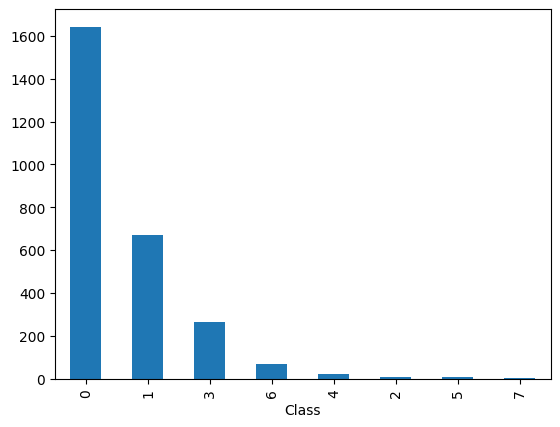

In [53]:
submission_df['Class'].value_counts().plot(kind='bar')

In [54]:
submission_df['Class'].value_counts()

Class
0    1642
1     672
3     265
6      68
4      24
2      10
5       9
7       4
Name: count, dtype: int64

# Evaluating final f1 score on val set

In [55]:
from sklearn.metrics import multilabel_confusion_matrix

val_dataset = TestDataset(dfval1, transform=get_transforms(data='valid',mean=mean1,std=std1))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point = torch.load('./'+f'{CFG.model_name}_best_1.pth')
model1 = CustomNet(CFG.model_name, pretrained=True)
model1.to(device)
model1.load_state_dict(check_point['model'])
pred_val1 = test_fun(val_loader, model1, device)
cf_matrix_individual1 = multilabel_confusion_matrix(dfval1["Class"],pred_val1)
cf_matrix1=confusion_matrix(dfval1["Class"],pred_val1)




In [56]:
val_dataset = TestDataset(dfval2, transform=get_transforms(data='valid',mean=mean2,std=std2))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point = torch.load('./'+f'{CFG.model_name}_best_2.pth')
model2 = CustomNet(CFG.model_name, pretrained=True)
model2.to(device)
model2.load_state_dict(check_point['model'])
pred_val2 = test_fun(val_loader, model2, device)
cf_matrix_individual2 = multilabel_confusion_matrix(dfval2["Class"],pred_val2)
cf_matrix2=confusion_matrix(dfval2["Class"],pred_val2)


In [57]:
val_dataset = TestDataset(dfval3, transform=get_transforms(data='valid',mean=mean3,std=std3))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point = torch.load('./'+f'{CFG.model_name}_best_3.pth')
model3 = CustomNet(CFG.model_name, pretrained=True)
model3.to(device)
model3.load_state_dict(check_point['model'])
pred_val3 = test_fun(val_loader, model3, device)
cf_matrix_individual3 = multilabel_confusion_matrix(dfval3["Class"],pred_val3)
cf_matrix3=confusion_matrix(dfval3["Class"],pred_val3)

In [58]:
val_dataset = TestDataset(dfval4, transform=get_transforms(data='valid',mean=mean4,std=std4))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point = torch.load('./'+f'{CFG.model_name}_best_4.pth')
model4 = CustomNet(CFG.model_name, pretrained=True)
model4.to(device)
model4.load_state_dict(check_point['model'])
pred_val4 = test_fun(val_loader, model4, device)
cf_matrix_individual4 = multilabel_confusion_matrix(dfval4["Class"],pred_val4)
cf_matrix4=confusion_matrix(dfval4["Class"],pred_val4)


In [59]:
val_dataset = TestDataset(dfval5, transform=get_transforms(data='valid',mean=mean5,std=std5))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
check_point = torch.load('./'+f'{CFG.model_name}_best_5.pth')
model5 = CustomNet(CFG.model_name, pretrained=True)
model5.to(device)
model5.load_state_dict(check_point['model'])
pred_val5 = test_fun(val_loader, model5, device)
cf_matrix_individual5 = multilabel_confusion_matrix(dfval5["Class"],pred_val5)
cf_matrix5=confusion_matrix(dfval5["Class"],pred_val5)

In [60]:
f1_score=sklearn.metrics.f1_score(dfval1["Class"],pred_val1,average=None,zero_division='warn')
f1_score

array([0.89361702, 0.82333874, 0.76923077, 0.625     , 0.99684543,
       0.7826087 , 0.94444444, 1.        ])

In [61]:
f1_score=sklearn.metrics.f1_score(dfval2["Class"],pred_val2,average=None,zero_division='warn')
f1_score

array([0.93216855, 0.87344029, 0.83809524, 0.81967213, 0.98422713,
       0.60606061, 1.        , 0.90909091])

In [62]:
f1_score=sklearn.metrics.f1_score(dfval3["Class"],pred_val3,average=None,zero_division='warn')
f1_score

array([0.9309052 , 0.84761905, 0.91803279, 0.8603352 , 1.        ,
       0.52631579, 0.99173554, 1.        ])

In [63]:
f1_score=sklearn.metrics.f1_score(dfval4["Class"],pred_val4,average=None,zero_division='warn')
f1_score

array([0.94441503, 0.8605042 , 0.93442623, 0.93617021, 1.        ,
       0.73684211, 0.97478992, 0.9375    ])

In [64]:
f1_score=sklearn.metrics.f1_score(dfval5["Class"],pred_val5,average=None,zero_division='warn')
f1_score

array([0.94213198, 0.89416058, 0.95495495, 0.78709677, 0.94630872,
       0.57142857, 0.95495495, 1.        ])

# Function to view image

In [65]:
def view_img(Label,Number):
    path=dftrain[dftrain['Class']==Label]['path'].values[Number]
    return Image.open(path)
    

In [66]:
dftrain['Class'].value_counts().sort_index()

Class
0    4829
1    1405
2     285
3     443
4     789
5      68
6     295
7      87
Name: count, dtype: int64

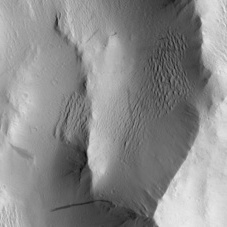

In [67]:
view_img(3,331)